## Analysis of Low Carbon and Gas-Fired Power Generation in the UK

In the UK, electricity is currently generated from a mix of  **low-carbon sources** (wind, solar, hydro, nuclear and biomass) and **gas-fired power plants**.  The UK's last operational coal-fired power station, Ratcliffe-on-Soar in Nottinghamshire, ceased operations on September 30, 2024, marking the end of 142 years of coal-powered electricity generation in the country. 

**Objective**

This analysis aims to:
- Assess when low-carbon generation surpasses gas-fired generation.
- Examine contribution of each generation sources during tight margin periods. The detailed analysis of Operational Planning Margin analysis is available at: [Analysis: OPMR](https://github.com/SwatiInd/UK-Power-Analysis/blob/main/Operational_planning_margin.ipynb)
- Identify the operational patterns of flexible energy sources (storage and hydro) during critical periods.

**Notebook structure**
1. **Data collection and processing**
    - Retrieving generation mix data from **National Energy System Operator (NESO)**.
    - Clean, transfor, andm prepare the dataset for analysis.

2. **Data selction and aggregation**
    - Select data from **Jan-23**.
    - Aggregate data to daily and monthly frequency for analysis.

3. **Dominance of low-carbon over gas-fired generation**
    - Identify months when **wind generation exceeded gas-fired generation.**
    - Analyze whether a **windy or sunny day** can generate enough power to significantly **reduce gas dependency**.

4. **Energy mix during tight margin periods**
    - Examine how different generation sources contribute during **high-demand, low-supply periods**.

5. **Operations of flexible energy sources**
    - Determine the **operational patterns** of **storage and hydro** power sources.

6. **Conclusion**
    - Summarise key findings from sections 3 to 5.
    - Highlight **insights relevant to electricity pricing and forecasting**.

In [1]:
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import urllib3

In [2]:
def neso_api_to_df(api: str):
    '''Fetches data from the NESO API and converts it into a Pandas DataFrame'''
    try:
        http = urllib3.PoolManager()
        request = http.request('GET', api)
        json_response = request.json() # NESO api returns data in JSON format
        listed_data = json_response['result']['records']
        df = pd.DataFrame(listed_data)
        return df
    except Exception as e:
        print(f"API request error: {e}")
        return pd.DataFrame()
    
def standardize_column_names(original_columns: list):
    '''Returns standardized columns name'''
    modified_columns = [col.lstrip('_').lower().replace(' ', '_').replace('/', '') for col in original_columns]
    return modified_columns

def get_short_term_data(df: pd.DataFrame, start_date: str, days: int):
    '''Extracts dataframe from the start date for number of days'''
    start_date = pd.to_datetime(start_date)
    end_date = start_date + timedelta(days = days)
    short_term_data = df[(df.index >= start_date)
                         &(df.index < end_date)].copy()
    return short_term_data.sort_index()

def plotting_day_data(settlement_gen, date_to_plot, columns_to_plot, axis, main_title, colors):
    '''Plots one-day settlement period wise generation data 
    and labels with total generation of each source'''
    df_to_plot = get_short_term_data(settlement_gen[columns_to_plot], date_to_plot, 1)
    total_gen_by_source = df_to_plot.sum(axis = 0)
    xticks = pd.date_range(df_to_plot.index.min(), df_to_plot.index.max(),  freq = '3h')
    for i, col in enumerate(df_to_plot.columns):
        col_label = col.capitalize() + ': ' + str(total_gen_by_source.loc[col].round(1)) + ' GWh'
        axis.plot(df_to_plot.index, df_to_plot[col], label= col_label, color=colors[col])
    
    axis.set_xlim(df_to_plot.index.min(), df_to_plot.index.max());
    axis.set_xticks(xticks);
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%#H'));
    start_date = pd.to_datetime(date_to_plot)
    year, month, day = start_date.strftime('%Y'), start_date.strftime('%b'), start_date.strftime('%#d')
    axis.set_title(main_title +  month + ' ' +day + ', ' + year);


def plotting_monthly_data(df, month_start_date, columns_to_plot, axis, main_title, colors, monthly_gen):
    df_to_plot = get_short_term_data(df[columns_to_plot],  month_start_date, 31)
    xticks = pd.date_range(df_to_plot.index.min()-timedelta(days = 1), df_to_plot.index.max(),  freq = '5d', inclusive='right')
    for i, col in enumerate(df_to_plot.columns):
        total_gen = monthly_gen.loc[month_start_date, col]/1000 #Converting GWh to TWh
        col_label = col.capitalize() + ': ' + str(total_gen.round(1)) + ' TWh'
        axis.plot(df_to_plot.index, df_to_plot[col], label=col_label, color=colors[col])
    
    axis.set_xlim(df_to_plot.index.min(), df_to_plot.index.max());
    axis.set_xticks(xticks);
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%#d'));
    month_start_date = pd.to_datetime(month_start_date)
    year, month = month_start_date.strftime('%y'), month_start_date.strftime('%b')
    axis.set_title(main_title +  month + '-' + year);


### Section I: Data collection and processing

- Retrieved generation mix data from the NESO API.
- Standardized column names for consistency and ease of analysis.
- Set the datetime column as the index to facilitate time-series analysis in subsequent sections.

In [3]:
generation_mix_api = 'https://api.neso.energy/api/3/action/datastore_search?resource_id=f93d1835-75bc-43e5-84ad-12472b180a98&limit=2000000'
generation_mix_df = neso_api_to_df(generation_mix_api)
# Standardizing column names
generation_mix_df.columns = standardize_column_names(generation_mix_df.columns)
# Setting datetime index
generation_mix_df.datetime = pd.to_datetime(generation_mix_df.datetime)
generation_mix_df.set_index('datetime', inplace = True)
print('The raw data is available from: ',
generation_mix_df.index.min().strftime('%Y-%d-%m'), 'to ' ,generation_mix_df.index.max().strftime('%Y-%d-%m'))

The raw data is available from:  2009-01-01 to  2025-01-04


#### Section II: Data selection and aggregation
- **Selection of analysis period**: The UK’s energy system is undergoing a major transition, shifting from coal as a significant contributor to its complete phase-out. This analysis focuses on the recent energy mix, starting from January 2023, to capture these changes. 
- **Wind power generation**: Wind Power Generation: Wind generation consists of two components—embedded and metered. Both are combined and presented together in all subsequent analyses.

- **Data aggregation**:
    - Analyzing half-hourly data over long periods is complex, so the data is aggregated at daily and monthly levels for sections III to V.
    - Individual generators’ power output is summed at daily and monthly levels.
    - The percentage contribution of each generator is calculated for the same periods.

    Using aggregated daily, weekly, and monthly generation data, the next section explores trends and insights. To ensure consistent data visualization, the same color scheme is used for all generators across figures.

In [4]:
generators = ['gas', 'coal',  'nuclear', 'wind', 'hydro', 'imports', 'biomass', 'other',  'solar', 'storage', ]   
generators_colors = {'gas':'#E69F00',  # fire and combustion
          'nuclear': 'purple', # Often associated with radiation and nuclear energy.
          'wind' : '#56B4E9', # Represents air and the sky
          'solar': 'yellow',  #  Naturally represents sunlight.
          'imports':'green',    #Can symbolize external energy, sustainability, or neutrality.
          'storage':'gray', #Neutral, since storage can come from multiple sources.
          'hydro': '#0072B2', # represents water
        'others': '#666666'
          }

In [5]:
# Extracting data for analyzing periods (from Jan 23)
df = generation_mix_df[generation_mix_df.index >=pd.to_datetime('2023-1-1')].copy()
df = df.sort_index()
# Adding metered and embedded wind 
df['wind_total'] = df['wind'] + df['wind_emb']
df.drop(['wind', 'wind_emb'], axis = 1, inplace = True)
df.rename(columns = {'wind_total': 'wind'}, inplace = True)
# Converting power from MW to GWh
settlement_gen = df[generators]/(2*1000)   
#Daily sum and percentage
daily_gen = settlement_gen.resample('D').sum()
for col in daily_gen.columns:
    daily_gen.loc[:, col+'_perc'] = 100*daily_gen[col]/daily_gen.sum(axis = 1)
# Monthly sum and percentage
monthly_gen = settlement_gen.resample('MS').sum()
for col in monthly_gen.columns:
    monthly_gen.loc[:, col+'_perc'] = 100*monthly_gen[col]/monthly_gen.sum(axis = 1)

### Section 3: Dominance of low-carbon over gas-fired generation

The UK is committed to achieving net-zero carbon emissions by 2050. This goal involves three key sectors: electricity, heat, and transport. In this section, we focus on electricity generation, identifying periods—either monthly or daily—where low-carbon sources (wind, solar, hydro, nuclear, and biomass) surpassed gas-fired generation.

#### Section 3.1:  Identifying Months When Wind Power Outpaced Gas Generation
With the UK’s wind power capacity steadily increasing, we analyze whether **monthly wind generation** has exceeded that of **gas-fired plants**. Additionally, we illustrate **daily generation patterns** for **December 2023** and **April 2024**, highlighting dominance of wind over gas.

In [6]:
higher_wind_index = monthly_gen[monthly_gen.wind > monthly_gen.gas].index
years = higher_wind_index.year.unique()
print('Monthly aggregated power generation  from wind turbines was higher than gas-fired sources for the following months:')
for year in years:
    months = higher_wind_index[higher_wind_index.year == year].strftime('%b').tolist()
    print( year, ':', months)

Monthly aggregated power generation  from wind turbines was higher than gas-fired sources for the following months:
2023 : ['Jan', 'Oct', 'Dec']
2024 : ['Feb', 'Mar', 'Apr', 'Jun', 'Aug', 'Sep', 'Oct', 'Dec']


In [7]:
(monthly_gen.wind - monthly_gen.gas).nlargest(2)

datetime
2024-04-01    4140.0710
2023-12-01    3642.1795
Freq: -4MS, dtype: float64

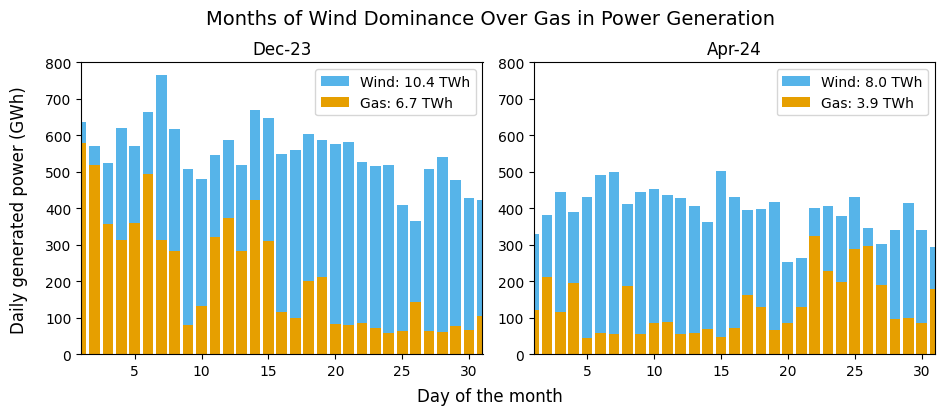

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4));
start_dates = [ '2023-12-01', '2024-04-01']

for index, axis in enumerate(ax.flatten()):
    month_start_date = start_dates[index]
    df_to_plot = get_short_term_data(daily_gen[['wind', 'gas']],  month_start_date, 31)
    monthly_data = monthly_gen.loc[month_start_date, ['wind', 'gas']]
    gas_label = 'Gas: ' + str((monthly_gen.loc[month_start_date, 'gas']/1000).round(1)) + str(' TWh')
    wind_label = 'Wind: ' + str((monthly_gen.loc[month_start_date, 'wind']/1000).round(1)) + str(' TWh')
    xticks = pd.date_range(df_to_plot.index.min()-timedelta(days = 1), df_to_plot.index.max(),  freq = '5d', inclusive='right')

    axis.bar(df_to_plot.index,df_to_plot['wind'], label= wind_label, color= generators_colors['wind'], bottom = df_to_plot['gas'],)
    axis.bar(df_to_plot.index,df_to_plot['gas'],  color = generators_colors['gas'], label = gas_label)
    axis.legend(ncol = 1)
    axis.set_ylim([0, 800])

    axis.set_xlim(df_to_plot.index.min(), df_to_plot.index.max());
    axis.set_xticks(xticks);
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%#d'));
    month_start_date = pd.to_datetime(month_start_date)
    year, month = month_start_date.strftime('%y'), month_start_date.strftime('%b')
    axis.set_title(month + '-' + year);

# Adjusting the rectangle of figures to accommodate figure titles
fig.tight_layout(rect = (0.04,0.04, 0.96, 0.96)) 
fig.supxlabel('Day of the month');
fig.supylabel('Daily generated power (GWh)');
fig.suptitle('Months of Wind Dominance Over Gas in Power Generation', y = 1, fontsize = 14);

#### Section 3.2: Daily Generation Led by Wind/Solar
Wind and solar power generation are intermittent, making it crucial to assess their contribution to the UK’s overall power demand. In this section, we analyze how much these variable renewable energy sources can support the grid on days of maximum wind and solar generation.

To provide a comprehensive view, we examine the key components of the UK’s power mix—wind, solar, storage, gas, nuclear, and imports—on these high-generation days, highlighting their relative contributions and overall impact on the energy system.

In [9]:
daily_gen.wind.idxmax(), daily_gen.solar.idxmax()

(Timestamp('2024-12-22 00:00:00'), Timestamp('2024-06-02 00:00:00'))

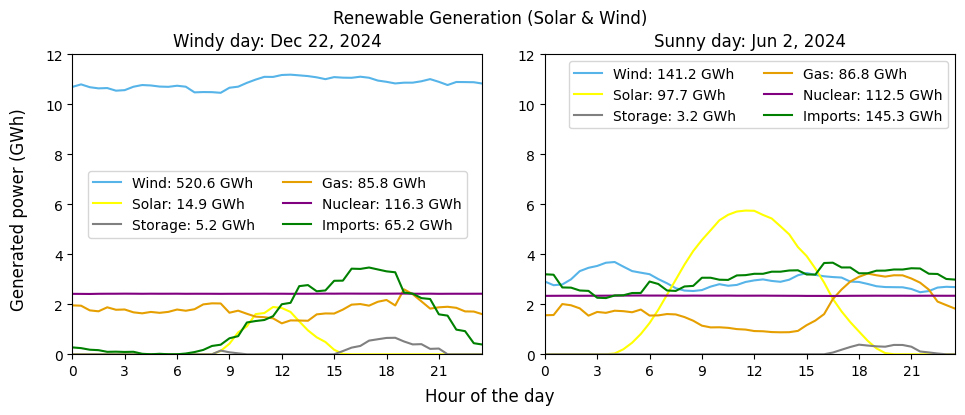

In [16]:
dates = ['2024-12-22', '2024-6-2']
titles = ['Windy day: ', 'Sunny day: ']
columns_to_plot = ['wind', 'solar',  'storage' ,'gas', 'nuclear',   'imports',]
fig, ax = plt.subplots(1, 2, figsize = (10,4));
for index, axis in enumerate(ax.flatten()):
    plotting_day_data(settlement_gen, dates[index], columns_to_plot, axis, main_title = titles[index], colors = generators_colors)
    axis.set_ylim([0, 12])
ax[0].legend(ncols = 2, loc = 'center');
ax[1].legend(ncols = 2, );
# Adjusting the rectangle of figures to accommodate figure titles
fig.tight_layout(rect = (0.04,0.04, 0.98, 0.98)) 
fig.supxlabel('Hour of the day');
fig.supylabel('Generated power (GWh)');
fig.suptitle('Renewable Generation (Solar & Wind)', y = 1);

**Key Observations on Renewable Generation & Gas Dependency**
- Even during winter, a windy day, along with interconnectors and nuclear power, can significantly contribute to meeting demand. This leads to lower reliance on gas-fired power stations, reducing overall carbon emissions.

- On a sunny summer day, the figure confirms that gas-fired generation is mainly required during evening periods when solar power declines.

### Section 4: Tight margin days

From previous analyses, we identified periods with **negative generation availability margins**, where supply was critically tight:
1. December 11–12, 2025
2. January 10, 2025
3. January 20–22, 2025

To examine system stress, we analyze generation from major sources on December 11, 2024, and January 22, 2025. On these days:
- Gas was the dominant generation source, leading to high carbon emissions.
- Imports and nuclear generation remained relatively stable, showing their role in providing a consistent supply.

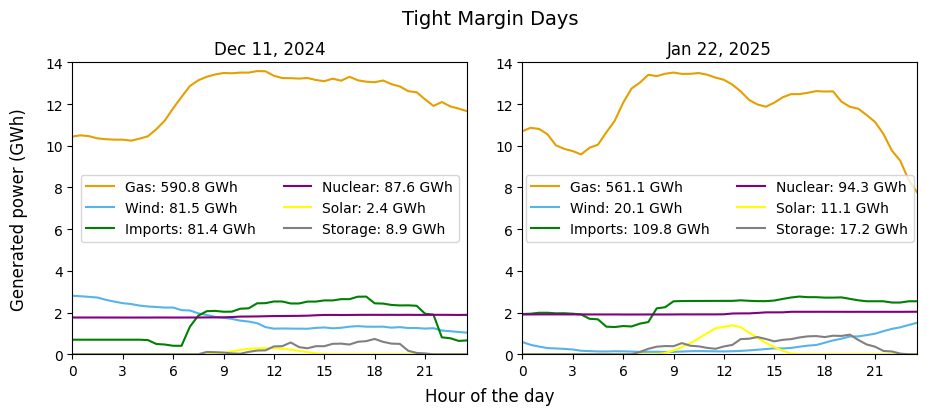

In [17]:
dates = ['2024-12-11',   '2025-1-22']
titles = ['', '', '', '']
columns_to_plot = ['gas',   'wind', 'imports',  'nuclear','solar', 'storage']
fig, ax = plt.subplots(1, 2, figsize = (10,4));
for index, axis in enumerate(ax.flatten()):
    plotting_day_data(settlement_gen[columns_to_plot], dates[index], columns_to_plot, axis, main_title = titles[index], 
                      colors = generators_colors)
    axis.set_ylim([0, 14])
ax[0].legend(ncols = 2, loc = 'center');
ax[1].legend(ncols = 2, loc = 'center');
# Adjusting the rectangle of figures to accommodate figure titles
fig.tight_layout(rect = (0.04,0.04, 0.96, 0.96)) 
fig.supxlabel('Hour of the day');
fig.supylabel('Generated power (GWh)');
fig.suptitle('Tight Margin Days', y = 1, fontsize = 14);

### Section 5: Flexible Generation Sources
Hydro, storage, and CHP are zero-emission flexible generation sources that complement solar and wind by providing fast-response power—able to ramp up or down within minutes or even seconds. These sources typically generate more power during morning and evening periods, helping to balance supply and demand when solar and wind output fluctuate.

In this section, we explore When these flexible sources are most utilized throughout the day. This analysis would develop understanding how these sources provide grid stability and reduce reliance on gas-fired generation.

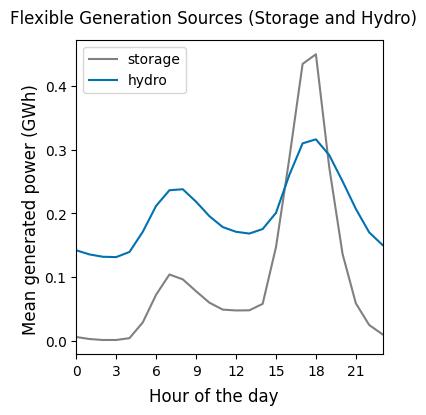

In [19]:
mean_by_hour = settlement_gen[['storage', 'hydro']].groupby(settlement_gen.index.hour).agg('mean')
mean_by_hour.index
fig, axis = plt.subplots(1, 1, figsize = (4,4));
df_to_plot = mean_by_hour
xticks = np.arange(df_to_plot.index.min(), df_to_plot.index.max(), 3)
for i, col in enumerate(df_to_plot.columns):
    axis.plot(df_to_plot.index, df_to_plot[col], label=col, color= generators_colors[col])
axis.set_xlim(df_to_plot.index.min(), df_to_plot.index.max());
axis.set_xticks(xticks);
axis.legend();
# Adjusting the rectangle of figures to accommodate figure titles
fig.tight_layout(rect = (0.04,0.04, 0.96, 0.96)) 
fig.supxlabel('Hour of the day');
fig.supylabel('Mean generated power (GWh)');
fig.suptitle('Flexible Generation Sources (Storage and Hydro)', y = 1);


### Section 6: Conclusion

#### Section 6.1: Analysis Outcomes

In 2023, wind power generation surpassed gas for three months (January, October, and December). This trend further improved in 2024, with wind dominating over gas for eight months. Notably, in April 2024 and December 2023, wind power generation exceeded gas power by 4.1 TWh and 3.6 TWh, respectively. On particularly windy days, wind power can meet the majority of the UK's electricity demand.

Similarly, when solar generation is high and electricity demand is low, dependence on gas significantly decreases. Looking ahead, the electricity system requires upgrades in storage capacity and wind energy infrastructure to achieve net-zero electricity. During tight margin days, such as January 20, 2025, storage solutions operated continuously throughout the day, highlighting the crucial role of batteries and other storage technologies in system stability during periods of high demand stress. Therefore, expanding storage capacity remains a key priority for the future.

#### Section 6.2: Key Takeaways for Price Analysis and Forecasting

- It would be valuable to explore electricity pricing trends during periods when low-emission sources dominated over gas and vice versa.

- During tight margin situations, an analysis of price trends for gas, storage, interconnectors, and nuclear energy could provide deeper insights.

- On days when wind and solar generation were not sufficiently high, assessing their respective price trends would be beneficial in understanding market dynamics.